In [1]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
# from gerrychain.proposals import ReCom
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.tree import recursive_seed_part
# from gerrychain.updaters import Tally
from functools import partial
import pandas as pd
import json
import requests
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
response = json.loads(requests.get("https://people.csail.mit.edu/ddeford/BG/BG_05.json").text)
graph = Graph(json_graph.adjacency_graph(response))

In [3]:
POPCOL = "TOTPOP"
SEN_DISTS = 35
EPS = 0.02
TOTPOP = sum(graph.nodes()[n][POPCOL] for n in graph.nodes())

In [4]:
sddict = recursive_seed_part(graph, range(SEN_DISTS), TOTPOP/SEN_DISTS, POPCOL, EPS)

In [5]:
chain_updaters = {
                    "population": updaters.Tally(POPCOL, alias="population"),
                    "VAP": updaters.Tally("VAP"),
                    "BVAP": updaters.Tally("BVAP")
                 }
part = Partition(graph, sddict, chain_updaters)

In [6]:
proposal = partial(proposals.recom,
                    pop_col=POPCOL,
                    pop_target=TOTPOP/SEN_DISTS,
                    epsilon=EPS,
                    node_repeats=1)
cons = constraints.within_percent_of_ideal_population(part,EPS)

In [7]:
gingles = Gingleator(proposal, cons, part, 
                     minority_pop_col="BVAP", total_pop_col="VAP",
                     score_function=Gingleator.reward_partial_dist)

In [8]:
total_steps = 10000

In [9]:
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(gingles.short_bursts(10, 1000, with_progress_bar=True)):
    max_scores_sb[i] = gingles.best_score
    scores_sb[i] = gingles.score(part)

100%|█████████████████████████████████████| 10000/10000 [06:00<00:00, 27.72it/s]


In [10]:
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(gingles.simulated_annealing(total_steps, gingles.hot_cold_cycle_beta_function_factory(1000, 4000),
                                                     beta_magnitude=500, with_progress_bar=True)):
    max_scores_anneal[i] = gingles.best_score
    scores_anneal[i] = gingles.score(part)

100%|█████████████████████████████████████| 10000/10000 [07:02<00:00, 23.66it/s]


In [11]:
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(gingles.tilted_run(total_steps, 0.125, with_progress_bar=True)):
    max_scores_tilt[i] = gingles.best_score
    scores_tilt[i] = gingles.score(part)

100%|█████████████████████████████████████| 10000/10000 [07:04<00:00, 23.57it/s]


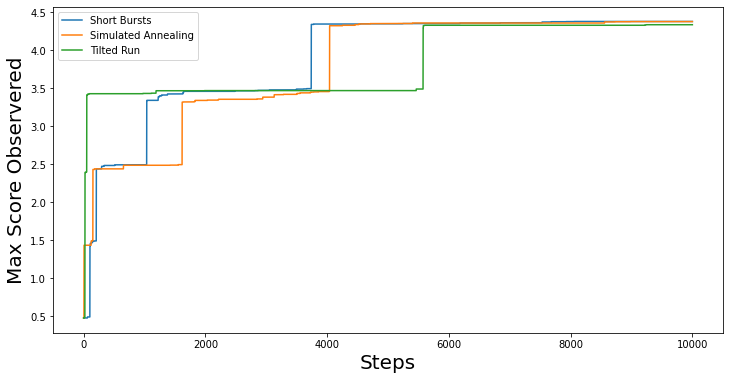

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Score Observered", fontsize=20)
plt.legend()
plt.show()

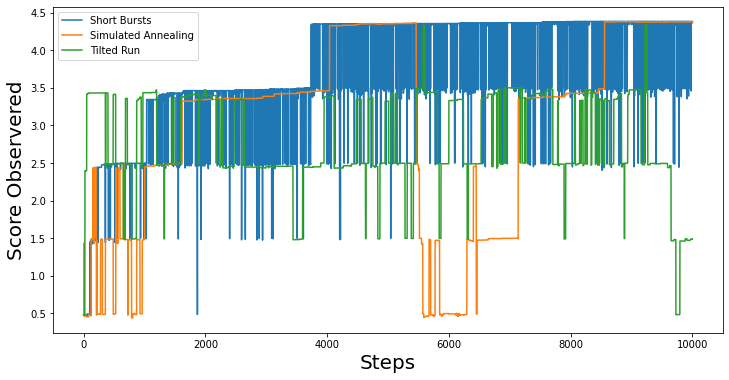

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(scores_sb, label="Short Bursts")
plt.plot(scores_anneal, label="Simulated Annealing")
plt.plot(scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Score Observered", fontsize=20)
plt.legend()
plt.show()